In [1]:
import xarray as xr
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import psutil
import time
import seaborn as sns
from matplotlib.colors import ListedColormap


In [2]:
def print_memory_usage(step):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"{step} - Memory usage: {mem_info.rss / (1024 ** 2):.2f} MB")


In [3]:
def load_and_preprocess_data():
    print("Starting data load and preprocessing...")
    print_memory_usage("Before loading Zarr dataset")
    
    zarr_ds = xr.open_zarr(store='../shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
    print_memory_usage("After loading Zarr dataset")

    zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45, 90), time=slice('2022-09-01', '2022-12-31'))
    all_nan_dates = np.isnan(zarr_new["CHL"]).all(dim=["lon", "lat"]).compute()
    zarr_ds = zarr_new.sel(time=all_nan_dates == False)
    
    print_memory_usage("After selecting data and filtering NaNs")

    return zarr_ds


In [4]:

def prepare_data_for_pca(zarr_ds):
    print("Starting data preparation for PCA...")

    # Extract all feature names except for 'CHL', 'CHL_uncertainty', and 'time'
    features = ['adt', 'air_temp', 'curr_dir', 'curr_speed', 'mlotst', 'sla', 'so', 'sst', 'u_curr', 'u_wind', 'ug_curr', 'v_curr', 'v_wind', 'vg_curr']

    # Create a water mask using SST
    water_mask = ~np.isnan(zarr_ds['sst'].isel(time=0).values)
    
    # Stack all features into one array
    X = zarr_ds[features].to_array().stack(z=('lat', 'lon')).transpose('time', 'variable', 'z').values
    
    # Extract CHL data and apply log transformation
    y = (zarr_ds['CHL'].stack(z=('lat', 'lon')).values)

    print_memory_usage("After stacking and transposing data")

    # Apply water mask
    X = X[:, :, water_mask.flatten()]
    y = y[:, water_mask.flatten()]

    # Handle NaNs and infinite values
    X = np.nan_to_num(X, nan=np.nanmean(X), posinf=np.nanmax(X), neginf=np.nanmin(X))
    y = np.nan_to_num(y, nan=np.nanmean(y), posinf=np.nanmax(y), neginf=np.nanmin(y))

    print_memory_usage("After handling NaNs and infinite values")

    # Normalize data (separately for each feature)
    X_mean = np.mean(X, axis=(0, 2), keepdims=True)
    X_std = np.std(X, axis=(0, 2), keepdims=True)
    X_std[X_std == 0] = 1e-8  # Prevent division by zero
    X_normalized = (X - X_mean) / X_std

    # Normalize log(CHL) data
    y_mean = np.mean(y)
    y_std = np.std(y)
    y_normalized = (y - y_mean) / y_std

    print_memory_usage("After normalizing data")

    # Flatten the normalized data for PCA
    X_flattened = X_normalized.transpose(0, 2, 1).reshape(-1, len(features))
    y_flattened = y_normalized.flatten()

    print_memory_usage("After flattening data")

    return X_flattened, y_flattened, X_mean, X_std, y_mean, y_std, X.shape, features, water_mask


In [5]:

def pca_reconstruction_visualization(X, y, X_mean, X_std, y_mean, y_std, original_shape, features, lat, lon, water_mask, max_components=10):
    mse_list = []
    explained_variance_list = []
    feature_importance_list = []

    for n_components in range(1, max_components + 1):
        print(f"Performing PCA with {n_components} components...")

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
        
        # Reconstruct the features using inverse transform
        X_reconstructed = pca.inverse_transform(X_pca)
        
        # Use linear regression to predict log(CHL) from the reconstructed features
        coefficients = np.linalg.lstsq(X_reconstructed, y, rcond=None)[0]
        y_pred = X_reconstructed @ coefficients

        # De-normalize the predictions and convert back from log scale
        y_pred_denormalized = (y_pred * y_std) + y_mean
        y_denormalized = np.log((y * y_std) + y_mean)

        # Calculate the reconstruction error
        mse = mean_squared_error(y_denormalized, y_pred_denormalized)
        mse_list.append(mse)
        explained_variance_list.append(np.sum(pca.explained_variance_ratio_))

        # Calculate feature importance
        feature_importance = np.abs(pca.components_).mean(axis=0)
        feature_importance_list.append(feature_importance)

        # Visualize the actual and reconstructed CHL data
        time_point = 0  # Change this to visualize different time points

        # Function to add land areas back
        def add_land_back(data):
            full_data = np.full(water_mask.shape, np.nan)
            full_data[water_mask] = data
            return full_data

        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        actual_chl = add_land_back(y_denormalized.reshape(original_shape[0], -1)[time_point])
        plt.imshow(actual_chl, cmap='viridis')
        plt.title('Actual CHL Image')
        plt.colorbar(label='Chlorophyll Concentration')

        plt.subplot(1, 3, 2)
        reconstructed_chl = add_land_back(y_pred_denormalized.reshape(original_shape[0], -1)[time_point])
        plt.imshow(reconstructed_chl, cmap='viridis')
        plt.title(f'Reconstructed CHL with {n_components} components')
        plt.colorbar(label='Chlorophyll Concentration')

        plt.subplot(1, 3, 3)
        error = actual_chl - reconstructed_chl
        plt.imshow(error, cmap='coolwarm')
        plt.title('Reconstruction Error')
        plt.colorbar(label='Error Magnitude')

        plt.tight_layout()
        plt.show()

    # Plot MSE and explained variance ratio as functions of the number of components
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_components + 1), mse_list, marker='o')
    plt.title('MSE vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Squared Error')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_components + 1), explained_variance_list, marker='o')
    plt.title('Explained Variance vs. Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    
    plt.tight_layout()
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 10))
    feature_importance_array = np.array(feature_importance_list)
    
    # Create a custom colormap
    colors = sns.color_palette("husl", len(features))
    cmap = ListedColormap(colors)
    
    # Create a heatmap of feature importance
    sns.heatmap(feature_importance_array.T, cmap=cmap, annot=False, fmt='.2f', 
                xticklabels=range(1, max_components + 1), yticklabels=features)
    plt.title('Feature Importance Heatmap')
    plt.xlabel('Number of Components')
    plt.ylabel('Features')
    
    # Create a custom legend with common knowledge terms
    feature_explanations = {
        'adt': 'Absolute Dynamic Topography (sea surface height)',
        'air_temp': 'Air Temperature',
        'curr_dir': 'Current Direction',
        'curr_speed': 'Current Speed',
        'mlotst': 'Mixed Layer Depth',
        'sla': 'Sea Level Anomaly',
        'so': 'Salinity',
        'sst': 'Sea Surface Temperature',
        'u_curr': 'Eastward Current',
        'u_wind': 'Eastward Wind',
        'ug_curr': 'Geostrophic Eastward Current',
        'v_curr': 'Northward Current',
        'v_wind': 'Northward Wind',
        'vg_curr': 'Geostrophic Northward Current',
        'wind_dir': 'Wind Direction',
        'wind_speed': 'Wind Speed'
    }
    
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(features))]
    labels = [f"{feature}: {feature_explanations[feature]}" for feature in features]
    plt.legend(handles, labels, title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # Additional plot: Top 5 most important features per component
    plt.figure(figsize=(15, 10))
    for i in range(max_components):
        plt.subplot(4, 4, i+1)
        top_5_indices = np.argsort(feature_importance_array[i])[-5:]
        sns.barplot(x=feature_importance_array[i][top_5_indices], 
                    y=[features[j] for j in top_5_indices], 
                    palette=[colors[j] for j in top_5_indices])
        plt.title(f'Top 5 Features for {i+1} Components')
        plt.xlabel('Importance')
        plt.ylabel('')
    
    plt.tight_layout()
    plt.show()
    return feature_importance_list


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
def create_random_forest_model(X, y, feature_importance, features, lat, lon, water_mask, original_shape, n_components=6, n_estimators=100, tree_method='hist'):
    print("Starting XGBoost model creation...")
    
    # Select top features based on PCA feature importance
    print(f"Selecting top {n_components} features based on PCA feature importance...")
    top_features_indices = np.argsort(feature_importance[n_components-1])[::-1][:n_components]
    selected_features = [features[i] for i in top_features_indices]
    print(f"Selected features: {selected_features}")
    
    # Select the corresponding columns from X
    X_selected = X[:, top_features_indices]
    
    # Create latitude and longitude grids
    lat_grid, lon_grid = np.meshgrid(lat, lon)
    
    # Flatten and mask the latitude and longitude grids
    lat_flat = lat_grid.flatten()[water_mask.flatten()]
    lon_flat = lon_grid.flatten()[water_mask.flatten()]
    
    # Ensure lat_flat and lon_flat have the same length as X_selected
    if len(lat_flat) != X_selected.shape[0]:
        lat_flat = np.repeat(lat_flat, X_selected.shape[0] // len(lat_flat))
        lon_flat = np.repeat(lon_flat, X_selected.shape[0] // len(lon_flat))
    
    # Add lat and lon to X_selected
    X_with_coords = np.column_stack((X_selected, lat_flat, lon_flat))
    selected_features += ['latitude', 'longitude']
    
    print(f"Shape of selected feature matrix with coordinates: {X_with_coords.shape}")
    
    # Split the data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X_with_coords, y, test_size=0.2, random_state=42)
    print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")
    
    # Create and train the XGBoost model with GPU acceleration
    print(f"Creating XGBoost model with {n_estimators} estimators...")
    xgb_model = XGBRegressor(n_estimators=n_estimators, tree_method=tree_method, device = "cuda", random_state=42)
    
    print("Training XGBoost model...")
    xgb_model.fit(X_train, y_train)
    print("XGBoost model training completed.")
    
    # Make predictions
    print("Making predictions on test set...")
    y_pred = xgb_model.predict(X_test)
    
    # Calculate performance metrics
    print("Calculating performance metrics...")
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    
    # Get feature importances from XGBoost
    print("Extracting feature importances from XGBoost model...")
    xgb_feature_importance = xgb_model.feature_importances_
    
    # Plot XGBoost feature importances
    print("Plotting XGBoost feature importances...")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=xgb_feature_importance, y=selected_features)
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Visualize predicted chlorophyll concentrations
    print("Visualizing predicted chlorophyll concentrations...")
    
    # Function to add land areas back
    def add_land_back(data):
        full_data = np.full(water_mask.shape, np.nan)
        full_data[water_mask] = data
        return full_data
    
    # Predict for all data points
    y_all_pred = xgb_model.predict(X_with_coords)
    
    # Reshape predictions to original spatial dimensions
    y_pred_reshaped = add_land_back(y_all_pred.reshape(original_shape[0], -1)[0])
    y_actual_reshaped = add_land_back(y.reshape(original_shape[0], -1)[0])
    
    # Plot actual vs predicted chlorophyll concentrations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    im1 = ax1.imshow(y_actual_reshaped, cmap='viridis')
    ax1.set_title('Actual Chlorophyll Concentration')
    plt.colorbar(im1, ax=ax1, label='Chlorophyll Concentration')
    
    im2 = ax2.imshow(y_pred_reshaped, cmap='viridis')
    ax2.set_title('Predicted Chlorophyll Concentration')
    plt.colorbar(im2, ax=ax2, label='Chlorophyll Concentration')
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Chlorophyll Concentration')
    plt.ylabel('Predicted Chlorophyll Concentration')
    plt.title('Actual vs Predicted Chlorophyll Concentration')
    plt.tight_layout()
    plt.show()
    
    # Plot learning curve
    print("Plotting learning curve...")
    train_sizes, train_scores, test_scores = learning_curve(
        xgb_model, X_with_coords, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error')
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title('XGBoost Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Error')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    print("XGBoost model creation and evaluation completed.")
    return xgb_model, selected_features

In [7]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

def create_decision_tree_model(X, y, feature_importance, features, original_shape, water_mask, lat, lon, n_components=6):
    # Get the feature importance for 5 components
    importance = feature_importance[n_components - 1]
    
    # Sort features by importance
    sorted_features = [x for _, x in sorted(zip(importance, features), reverse=True)]
    
    # Select top features (you can adjust this number)
    top_features = sorted_features[:7]  # Let's use top 7 features
    
    # Create a new X dataset with only the top features
    X_top = X[:, [features.index(f) for f in top_features]]
    
    # Create latitude and longitude grids
    lat_grid, lon_grid = np.meshgrid(lat, lon)
    
    # Flatten and mask the latitude and longitude grids
    lat_flat = lat_grid.flatten()[water_mask.flatten()]
    lon_flat = lon_grid.flatten()[water_mask.flatten()]
    
    # Ensure lat_flat and lon_flat have the same length as X_top
    if len(lat_flat) != X_top.shape[0]:
        lat_flat = np.repeat(lat_flat, X_top.shape[0] // len(lat_flat))
        lon_flat = np.repeat(lon_flat, X_top.shape[0] // len(lon_flat))
    
    # Add lat and lon to X_top
    X_with_coords = np.column_stack((X_top, lat_flat, lon_flat))
    top_features += ['latitude', 'longitude']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_with_coords, y, test_size=0.2, random_state=42)
    
    # Create and train the decision tree model with limited depth
    dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)  # Adjust depth as needed
    dt_model.fit(X_train, y_train)
    
    # Evaluate the model
    train_score = dt_model.score(X_train, y_train)
    test_score = dt_model.score(X_test, y_test)
    
    print(f"Decision Tree R² score on training set: {train_score:.4f}")
    print(f"Decision Tree R² score on test set: {test_score:.4f}")
    
    # Extract tree rules
    tree_rules = export_text(dt_model, feature_names=top_features)
    print(tree_rules)
    
    # Visualize the decision tree (custom for latitude and longitude splits)
    def plot_tree_splits_on_lat_lon(tree, feature_names):
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold

        node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
        is_leaves = np.zeros(shape=n_nodes, dtype=bool)
        stack = [(0, -1)]  # start with the root node id (0) and its parent depth (-1)

        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1

            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                is_leaves[node_id] = True

        # Plotting
        fig, ax = plt.subplots(figsize=(30, 20))
        ax.set_title("Splits on Latitude and Longitude")
        for i in range(n_nodes):
            if is_leaves[i]:
                continue
            if feature_names[feature[i]] in ['latitude', 'longitude']:
                ax.plot(node_depth[i], i, 'bo')
                ax.text(node_depth[i], i, f"Node {i}\n({feature_names[feature[i]]} <= {threshold[i]:.2f})",
                        horizontalalignment='right', verticalalignment='bottom')

        ax.set_xlabel("Tree Depth")
        ax.set_ylabel("Node Index")
        plt.show()
    
    plot_tree_splits_on_lat_lon(dt_model, top_features)
    
    # Make predictions
    y_pred_test = dt_model.predict(X_test)

    # Visualize feature importances
    feature_importance = dt_model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=top_features)
    plt.title('Decision Tree Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Function to add land areas back
    def add_land_back(data):
        full_data = np.full(water_mask.shape, np.nan)
        full_data[water_mask] = data
        return full_data
    
    # Predict for all data points
    y_all_pred = dt_model.predict(X_with_coords)
    
    # Reshape predictions to original spatial dimensions
    y_pred_reshaped = add_land_back(y_all_pred.reshape(original_shape[0], -1)[0])
    y_actual_reshaped = add_land_back(y.reshape(original_shape[0], -1)[0])
    
    # Plot actual vs predicted chlorophyll concentrations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    im1 = ax1.imshow(y_actual_reshaped, cmap='viridis')
    ax1.set_title('Actual Chlorophyll Concentration')
    plt.colorbar(im1, ax=ax1, label='Chlorophyll Concentration')
    
    im2 = ax2.imshow(y_pred_reshaped, cmap='viridis')
    ax2.set_title('Predicted Chlorophyll Concentration')
    plt.colorbar(im2, ax=ax2, label='Chlorophyll Concentration')
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Chlorophyll Concentration')
    plt.ylabel('Predicted Chlorophyll Concentration')
    plt.title('Actual vs Predicted Chlorophyll Concentration')
    plt.tight_layout()
    plt.show()
    import geopandas as gpd
    
    
    def plot_tree_splits_on_lat_lon_with_countries(tree, feature_names, lat_grid, lon_grid):
        import matplotlib.pyplot as plt
        # Load world countries data (example using geopandas and Natural Earth data)
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
        n_nodes = tree.tree_.node_count
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        feature = tree.tree_.feature
        threshold = tree.tree_.threshold
    
        node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
        is_leaves = np.zeros(shape=n_nodes, dtype=bool)
        stack = [(0, -1)]  # start with the root node id (0) and its parent depth (-1)
    
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            node_depth[node_id] = parent_depth + 1
    
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                is_leaves[node_id] = True
    
        # Plotting
        fig, ax = plt.subplots(figsize=(100, 100))
        ax.set_title("Splits on Latitude and Longitude with Country Boundaries")
        world.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot countries as background
    
        for i in range(n_nodes):
            if is_leaves[i]:
                continue
            if feature_names[feature[i]] in ['latitude', 'longitude']:
                split_feature = feature_names[feature[i]]
                split_value = threshold[i]
                if split_feature == 'latitude':
                    ax.axhline(split_value, color='b', linestyle='--', linewidth=2)
                    ax.text(lon_grid.min(), split_value, f"Node {i}\nDepth {node_depth[i]}\n({split_feature} <= {split_value:.2f})",
                            horizontalalignment='left', verticalalignment='bottom', fontsize=12, color='blue')
                elif split_feature == 'longitude':
                    ax.axvline(split_value, color='r', linestyle='--', linewidth=2)
                    ax.text(split_value, lat_grid.min(), f"Node {i}\nDepth {node_depth[i]}\n({split_feature} <= {split_value:.2f})",
                            horizontalalignment='right', verticalalignment='top', fontsize=12, color='red')
    
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.imshow(lat_grid, extent=(lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()), cmap='viridis', alpha=0.3)
        plt.colorbar(label='Latitude')
        plt.show()
    
    # Call the updated function in your main function
    plot_tree_splits_on_lat_lon_with_countries(dt_model, top_features, lat_grid, lon_grid)

    return dt_model, top_features


In [8]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def plot_lasso_path(X, y, feature_names, alphas):
    # Fit the LASSO model for each alpha
    coefs = []
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
    
    # Plot the path of feature weights
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Weights')
    plt.title('LASSO Paths')
    plt.legend(feature_names, loc='best')
    plt.axis('tight')
    plt.show()

def create_lasso_model(X, y, feature_importance, features, original_shape, water_mask, lat, lon, n_components=6):
    # Get the feature importance for 5 components
    importance = feature_importance[n_components - 1]
    
    # Sort features by importance
    sorted_features = [x for _, x in sorted(zip(importance, features), reverse=True)]
    
    # Select top features (you can adjust this number)
    top_features = sorted_features[:7]  # Let's use top 10 features
    
    # Create a new X dataset with only the top features
    X_top = X[:, [features.index(f) for f in top_features]]
    
    # Create latitude and longitude grids
    lat_grid, lon_grid = np.meshgrid(lat, lon)
    
    # Flatten and mask the latitude and longitude grids
    lat_flat = lat_grid.flatten()[water_mask.flatten()]
    lon_flat = lon_grid.flatten()[water_mask.flatten()]
    
    # Ensure lat_flat and lon_flat have the same length as X_top
    if len(lat_flat) != X_top.shape[0]:
        lat_flat = np.repeat(lat_flat, X_top.shape[0] // len(lat_flat))
        lon_flat = np.repeat(lon_flat, X_top.shape[0] // len(lon_flat))
    
    # Add lat and lon to X_top
    X_with_coords = np.column_stack((X_top, lat_flat, lon_flat))
    top_features += ['latitude', 'longitude']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_with_coords, y, test_size=0.2, random_state=42)
    
    # Perform LASSO path visualization
    alphas = np.logspace(-4, 0, 100)
    plot_lasso_path(X_train, y_train, top_features, alphas)
    
    # Create and train the LASSO model with cross-validation to find the best alpha
    lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, precompute=False)
    lasso_cv.fit(X_train, y_train)
    
    # Evaluate the model
    train_score = lasso_cv.score(X_train, y_train)
    test_score = lasso_cv.score(X_test, y_test)
    
    print(f"LASSO R² score on training set: {train_score:.4f}")
    print(f"LASSO R² score on test set: {test_score:.4f}")
    
    # Visualize the coefficients
    coef = lasso_cv.coef_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coef, y=top_features)
    plt.title('LASSO Coefficients')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    # Make predictions
    y_pred_test = lasso_cv.predict(X_test)
    
    # Function to add land areas back
    def add_land_back(data):
        full_data = np.full(water_mask.shape, np.nan)
        full_data[water_mask] = data
        return full_data
    
    # Predict for all data points
    y_all_pred = lasso_cv.predict(X_with_coords)
    
    # Reshape predictions to original spatial dimensions
    y_pred_reshaped = add_land_back(y_all_pred.reshape(original_shape[0], -1)[0])
    y_actual_reshaped = add_land_back(y.reshape(original_shape[0], -1)[0])
    
    # Plot actual vs predicted chlorophyll concentrations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    im1 = ax1.imshow(y_actual_reshaped, cmap='viridis')
    ax1.set_title('Actual Chlorophyll Concentration')
    plt.colorbar(im1, ax=ax1, label='Chlorophyll Concentration')
    
    im2 = ax2.imshow(y_pred_reshaped, cmap='viridis')
    ax2.set_title('Predicted Chlorophyll Concentration')
    plt.colorbar(im2, ax=ax2, label='Chlorophyll Concentration')
    
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Chlorophyll Concentration')
    plt.ylabel('Predicted Chlorophyll Concentration')
    plt.title('Actual vs Predicted Chlorophyll Concentration')
    plt.tight_layout()
    plt.show()

    return lasso_cv, top_features


Starting data load and preprocessing...
Before loading Zarr dataset - Memory usage: 263.32 MB
After loading Zarr dataset - Memory usage: 415.61 MB
After selecting data and filtering NaNs - Memory usage: 434.38 MB
Starting data preparation for PCA...
After stacking and transposing data - Memory usage: 809.86 MB
After handling NaNs and infinite values - Memory usage: 757.21 MB
After normalizing data - Memory usage: 866.59 MB
After flattening data - Memory usage: 975.88 MB
Performing PCA with 1 components...


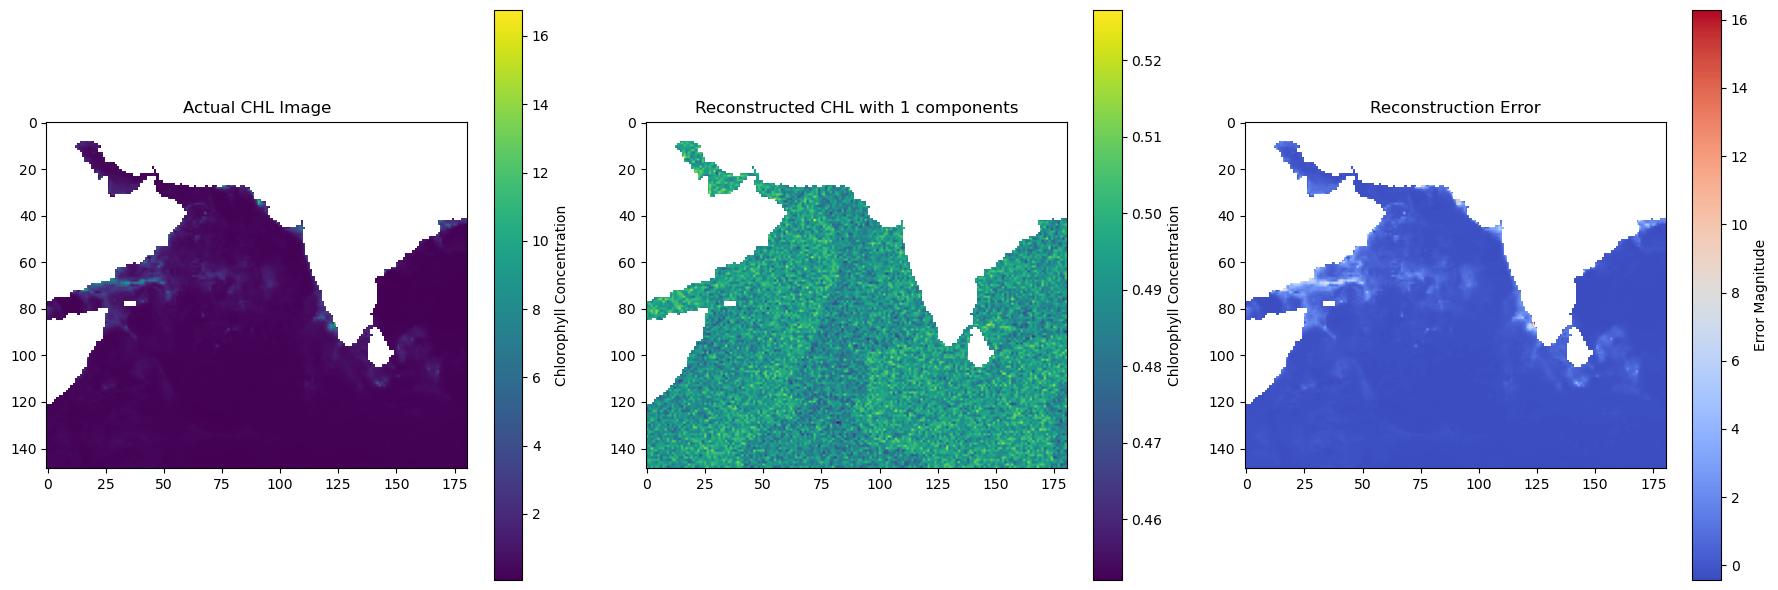

Performing PCA with 2 components...


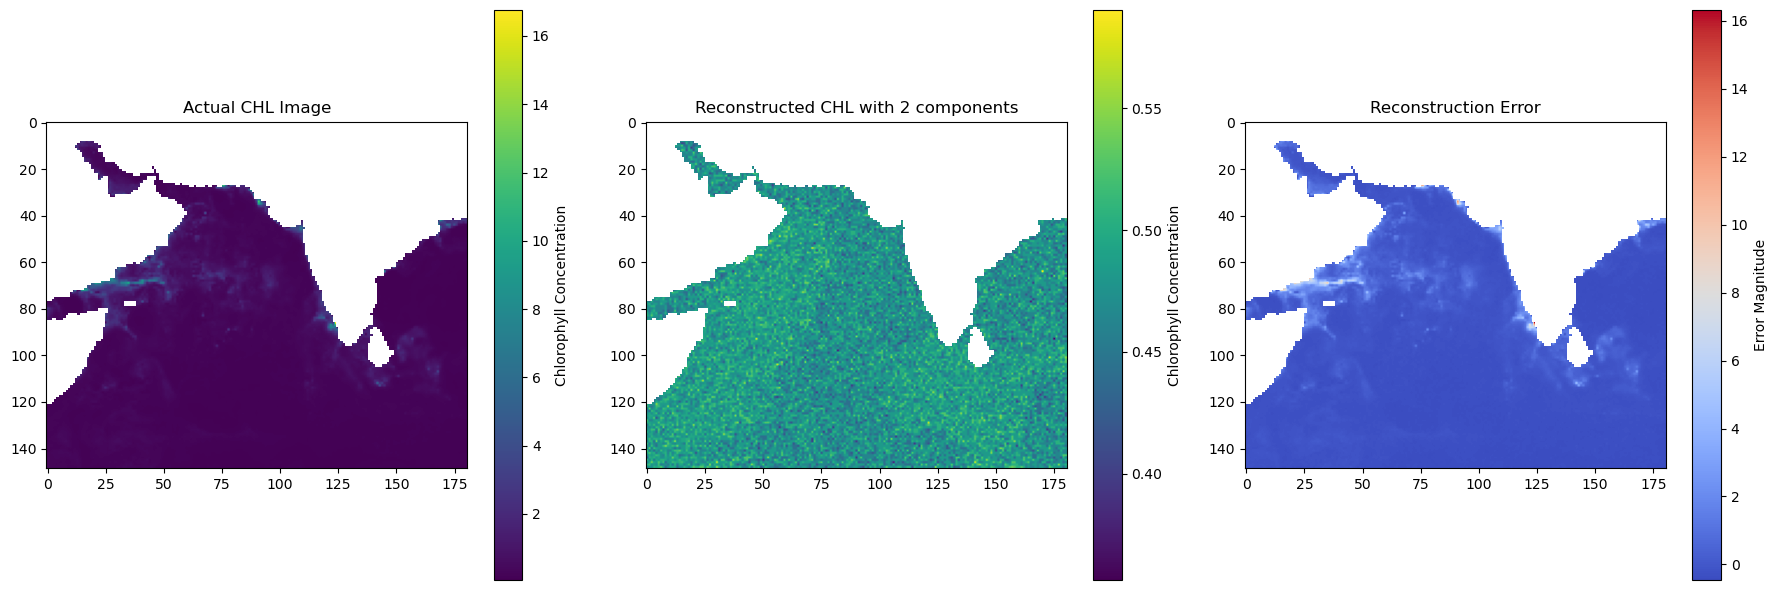

Performing PCA with 3 components...


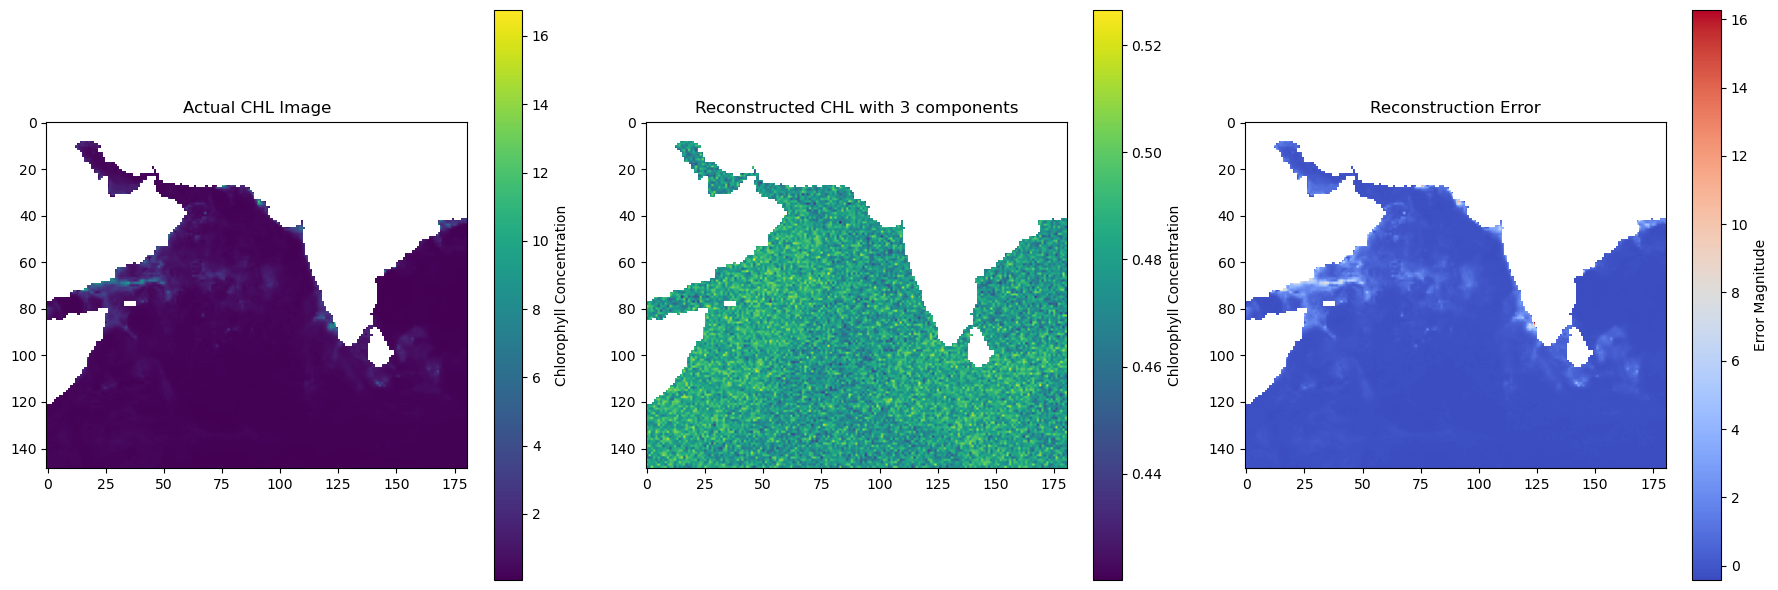

Performing PCA with 4 components...


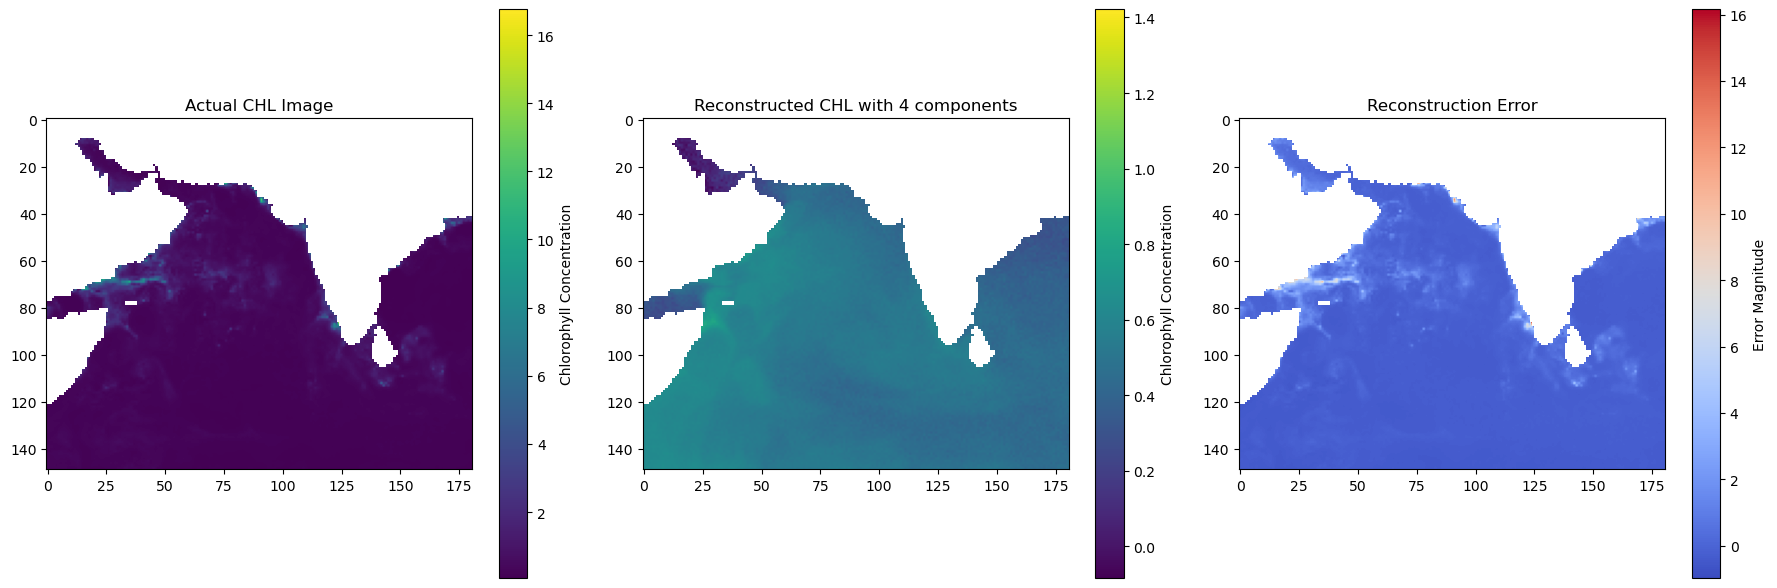

Performing PCA with 5 components...


KeyboardInterrupt: 

In [9]:
def main():
    zarr_ds = load_and_preprocess_data()
    
    # Extract latitude and longitude dimensions
    lat = zarr_ds['lat'].values
    lon = zarr_ds['lon'].values
    
    # Prepare data for PCA analysis
    X, y, X_mean, X_std, y_mean, y_std, original_shape, features, water_mask = prepare_data_for_pca(zarr_ds)
    
    # Perform PCA reconstruction visualization
    feature_importance_list = pca_reconstruction_visualization(X, y, X_mean, X_std, y_mean, y_std, original_shape, features, lat, lon, water_mask, max_components=14)
    # Create LASSO model
    '''lasso_model, top_features_lasso = create_lasso_model(X, y, feature_importance_list, features, original_shape, water_mask, lat, lon)

    # Print the top features used in the LASSO model
    print("Top features used in the LASSO model:")
    for i, feature in enumerate(top_features_lasso, 1):
        print(f"{i}. {feature}")'''
    # Create decision tree model
    #dt_model, top_features_dt = create_decision_tree_model(X, y, feature_importance_list, features, original_shape, water_mask, lat, lon)
    
    # Print the top features used in the decision tree
    #print("Top features used in the decision tree:")
    #for i, feature in enumerate(top_features_dt, 1):
    #    print(f"{i}. {feature}")
    
    # Create Random Forest model using PCA feature importance
    rf_model, selected_features_rf = create_random_forest_model(X, y, feature_importance_list, features, lat, lon, water_mask, original_shape, n_components=7, n_estimators=100)
    
    # Print the selected features used in the Random Forest model
    print("Selected features used in the Random Forest model:")
    for i, feature in enumerate(selected_features_rf, 1):
        print(f"{i}. {feature}")

if __name__ == "__main__":
    start_time = time.time()
    main()
    print(f"Execution time: {time.time() - start_time:.2f} seconds")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

def hyperparameter_tuning(X, y, n_iter=50):
    param_dist = {
        'n_estimators': [100,200,300,],
        'learning_rate': [0.01, 0.1, 0.002, 0.0003],
        'gamma': [0, 0.1, 0.2, 0.3],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    xgb_model = XGBRegressor(tree_method='hist', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=2,  # Set verbose to 2 for detailed output
        random_state=42,
        n_jobs=-1
    )

    print("Starting hyperparameter tuning with RandomizedSearchCV...")
    random_search.fit(X, y)
    print("Hyperparameter tuning completed.")

    return random_search.best_estimator_, random_search.best_params_
def main():
    zarr_ds = load_and_preprocess_data()
    X_flattened, y_flattened, X_mean, X_std, y_mean, y_std, original_shape, features, water_mask = prepare_data_for_pca(zarr_ds)

    best_model, best_params = hyperparameter_tuning(X_flattened, y_flattened)
    print("Best Parameters:", best_params)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_flattened, y_flattened, test_size=0.2, random_state=42)
    
    print("Training the best model on the training set...")
    best_model.fit(X_train, y_train)

    print("Predicting on the test set...")
    y_pred = best_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")

    # Learning curve
    print("Plotting learning curve...")
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_flattened, y_flattened, cv=3, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title('XGBoost Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Error')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Error')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print("Validation and evaluation completed.")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def load_and_preprocess_data():
    print("Starting data load and preprocessing...")
    
    # Load the Zarr dataset
    zarr_ds = xr.open_zarr(store='../shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
    
    # Select data up to 2019-12-31 and data from 2020
    zarr_train = zarr_ds.sel( time=slice('2016-01-01', '2019-12-31'))
    zarr_test = zarr_ds.sel( time=slice('2020-01-01', '2020-12-31'))
    
    # Remove days with all NaN CHL values
    all_nan_dates_train = np.isnan(zarr_train["CHL"]).all(dim=["lon", "lat"]).compute()
    all_nan_dates_test = np.isnan(zarr_test["CHL"]).all(dim=["lon", "lat"]).compute()
    zarr_train = zarr_train.sel(time=all_nan_dates_train == False)
    zarr_test = zarr_test.sel(time=all_nan_dates_test == False)
    
    return zarr_train, zarr_test

def load_and_preprocess_data2():
    print("Starting data load and preprocessing...")
    
    # Load the Zarr dataset
    zarr_ds = xr.open_zarr(store='../shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
    
    # Select data up to 2019-12-31 and data from 2020
    zarr_train = zarr_ds.sel( time=slice('2016-01-01', '2018-12-31'))
    zarr_test = zarr_ds.sel( time=slice('2019-01-01', '2019-12-31'))
    
    # Remove days with all NaN CHL values
    all_nan_dates_train = np.isnan(zarr_train["CHL"]).all(dim=["lon", "lat"]).compute()
    all_nan_dates_test = np.isnan(zarr_test["CHL"]).all(dim=["lon", "lat"]).compute()
    zarr_train = zarr_train.sel(time=all_nan_dates_train == False)
    zarr_test = zarr_test.sel(time=all_nan_dates_test == False)
    
    return zarr_train, zarr_test

def load_and_preprocess_data3():
    print("Starting data load and preprocessing...")
    
    # Load the Zarr dataset
    zarr_ds = xr.open_zarr(store='../shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
    
    # Select data up to 2019-12-31 and data from 2020
    zarr_train = zarr_ds.sel(time=slice('2016-01-01', '2020-12-31'))
    zarr_test = zarr_ds.sel(time=slice('2021-01-01', '2021-12-31'))
    
    # Remove days with all NaN CHL values
    all_nan_dates_train = np.isnan(zarr_train["CHL"]).all(dim=["lon", "lat"]).compute()
    all_nan_dates_test = np.isnan(zarr_test["CHL"]).all(dim=["lon", "lat"]).compute()
    zarr_train = zarr_train.sel(time=all_nan_dates_train == False)
    zarr_test = zarr_test.sel(time=all_nan_dates_test == False)
    
    return zarr_train, zarr_test
def prepare_data(zarr_ds):
    print("Preparing data...")

    features = ['adt', 'air_temp', 'curr_dir', 'curr_speed', 'mlotst', 'sla', 'so', 'sst', 'u_curr', 'u_wind', 'ug_curr', 'v_curr', 'v_wind', 'vg_curr']
    water_mask = ~np.isnan(zarr_ds['sst'].isel(time=0).values)
    
    X = zarr_ds[features].to_array().stack(z=('lat', 'lon')).transpose('time', 'variable', 'z').values
    y = ((zarr_ds['CHL']).stack(z=('lat', 'lon')).values)
    
    X = X[:, :, water_mask.flatten()]
    y = y[:, water_mask.flatten()]
    
    X = np.nan_to_num(X, nan=np.nanmean(X), posinf=np.nanmax(X), neginf=np.nanmin(X))
    y = np.nan_to_num(y, nan=np.nanmean(y), posinf=np.nanmax(y), neginf=np.nanmin(y))
    y = np.log(y)
    X_mean = np.mean(X, axis=(0, 2), keepdims=True)
    X_std = np.std(X, axis=(0, 2), keepdims=True)
    X_std[X_std == 0] = 1e-8
    X_normalized = (X - X_mean) / X_std

    y_mean = np.mean(y)
    y_std = np.std(y)
    y_normalized = (y - y_mean) / y_std

    X_flattened = X_normalized.transpose(0, 2, 1).reshape(-1, len(features))
    y_flattened = y_normalized.flatten()

    return X_flattened, y_flattened, X_mean, X_std, y_mean, y_std, X.shape, features, water_mask

def calculate_daily_mae(model, X_test, y_test, dates):
    print("Calculating daily MAE...")
    daily_mae = []
    for i in range(len(dates)):
        y_pred = model.predict(X_test[i::len(dates)])
        mae = mean_absolute_error(y_test[i::len(dates)], y_pred)
        daily_mae.append(mae)
    return daily_mae
def plot_chlorophyll_maps(actual, predicted, water_mask, date, lat, lon):
    def add_land_back(data):
        full_data = np.full(water_mask.shape, np.nan)
        full_data[water_mask] = data
        return full_data

    actual_img = add_land_back(actual)
    predicted_img = add_land_back(predicted)

    # Define extent to match the coordinate system of lat and lon
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]

    # Set consistent vmin and vmax for both images
    vmin = min(np.nanmin(actual_img), np.nanmin(predicted_img))
    vmax = max(np.nanmax(actual_img), np.nanmax(predicted_img))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    im1 = ax1.imshow(actual_img, cmap='viridis', extent=extent, origin='upper', vmin=vmin, vmax=vmax)
    ax1.set_title(f'True Chlorophyll Concentration\n{date}')
    plt.colorbar(im1, ax=ax1, label='Chlorophyll Concentration')

    im2 = ax2.imshow(predicted_img, cmap='viridis', extent=extent, origin='upper', vmin=vmin, vmax=vmax)
    ax2.set_title(f'Predicted Chlorophyll Concentration\n{date}')
    plt.colorbar(im2, ax=ax2, label='Chlorophyll Concentration')

    plt.tight_layout()
    plt.show()


def main():
    zarr_train, zarr_test = load_and_preprocess_data()
    lat = zarr_train['lat'].values
    lon = zarr_train['lon'].values
    
    X_train, y_train, X_mean, X_std, y_mean, y_std, _, features, water_mask = prepare_data(zarr_train)
    X_test, y_test, _, _, _, _, original_shape, _, _ = prepare_data(zarr_test)
    
    model = XGBRegressor(n_estimators=150, tree_method='hist', random_state=42 , learning_rate= 0.05, device = "cuda")
    model.fit(X_train, y_train)
    
    test_dates = zarr_test.time.values
    daily_mae = calculate_daily_mae(model, X_test, y_test, test_dates)
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, daily_mae, marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Daily MAE for Predicted Chlorophyll Concentration in 2020')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Visualize True and Predicted chlorophyll for an arbitrary day
    arbitrary_index = 0  # Choose any index within the range of available dates
    y_pred_arbitrary_day = model.predict(X_test[arbitrary_index::len(test_dates)])
    y_true_arbitrary_day = y_test[arbitrary_index::len(test_dates)]
    
    plot_chlorophyll_maps(y_true_arbitrary_day, y_pred_arbitrary_day, water_mask, str(test_dates[arbitrary_index]), lon, lat)
    
    zarr_train, zarr_test = load_and_preprocess_data2()
    lat = zarr_train['lat'].values
    lon = zarr_train['lon'].values
    
    X_train, y_train, X_mean, X_std, y_mean, y_std, _, features, water_mask = prepare_data(zarr_train)
    X_test, y_test, _, _, _, _, original_shape, _, _ = prepare_data(zarr_test)
    
    model = XGBRegressor(n_estimators=100, tree_method='hist', random_state=42 , learning_rate= 0.05, device = "cuda")
    model.fit(X_train, y_train)
    
    test_dates = zarr_test.time.values
    daily_mae = calculate_daily_mae(model, X_test, y_test, test_dates)
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, daily_mae, marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Daily MAE for Predicted Chlorophyll Concentration in 2020')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Visualize True and Predicted chlorophyll for an arbitrary day
    arbitrary_index = 0  # Choose any index within the range of available dates
    y_pred_arbitrary_day = model.predict(X_test[arbitrary_index::len(test_dates)])
    y_true_arbitrary_day = y_test[arbitrary_index::len(test_dates)]
    
    plot_chlorophyll_maps(y_true_arbitrary_day, y_pred_arbitrary_day, water_mask, str(test_dates[arbitrary_index]), lon, lat)
    zarr_train, zarr_test = load_and_preprocess_data3()
    lat = zarr_train['lat'].values
    lon = zarr_train['lon'].values
    
    X_train, y_train, X_mean, X_std, y_mean, y_std, _, features, water_mask = prepare_data(zarr_train)
    X_test, y_test, _, _, _, _, original_shape, _, _ = prepare_data(zarr_test)
    
    model = XGBRegressor(n_estimators=100, tree_method='hist', random_state=42 , learning_rate= 0.05, device = "cuda")
    model.fit(X_train, y_train)
    
    test_dates = zarr_test.time.values
    daily_mae = calculate_daily_mae(model, X_test, y_test, test_dates)
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, daily_mae, marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Daily MAE for Predicted Chlorophyll Concentration in 2020')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Visualize True and Predicted chlorophyll for an arbitrary day
    arbitrary_index = 0  # Choose any index within the range of available dates
    y_pred_arbitrary_day = model.predict(X_test[arbitrary_index::len(test_dates)])
    y_true_arbitrary_day = y_test[arbitrary_index::len(test_dates)]
    
    plot_chlorophyll_maps(y_true_arbitrary_day, y_pred_arbitrary_day, water_mask, str(test_dates[arbitrary_index]), lat, lon)

if __name__ == "__main__":
    main()

Starting data load and preprocessing...
Preparing data...
Preparing data...
[21:16:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693021084223/work/src/learner.cc:767: 
Parameters: { "device" } are not used.



Starting data load and preprocessing...
Preparing data...
Preparing data...
[20:58:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693021084223/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

Calculating daily MAE...


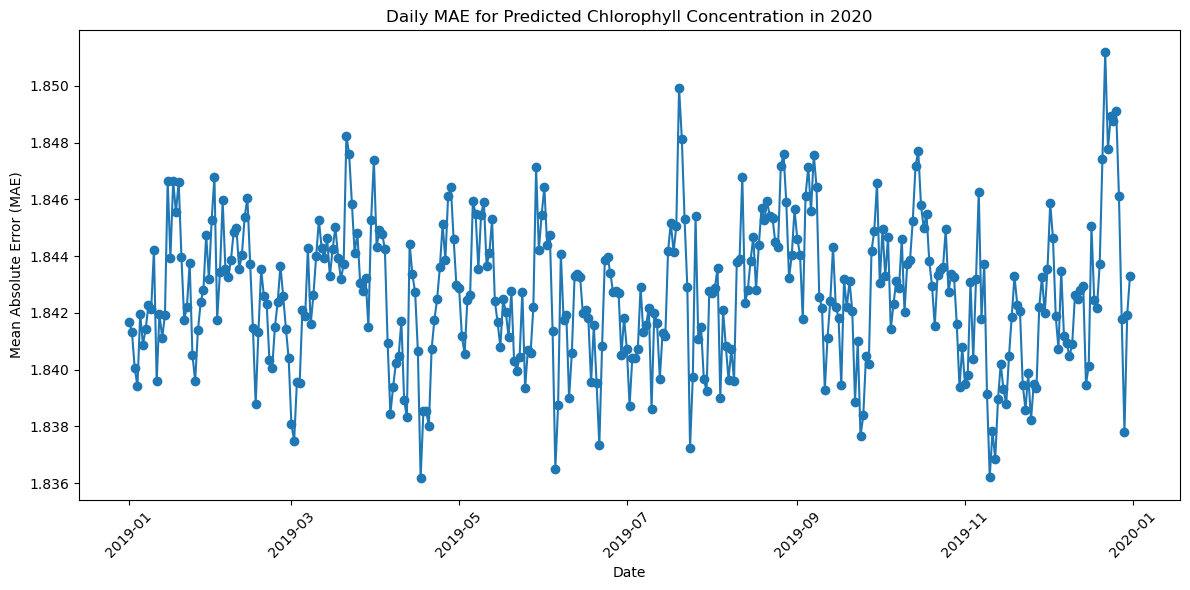

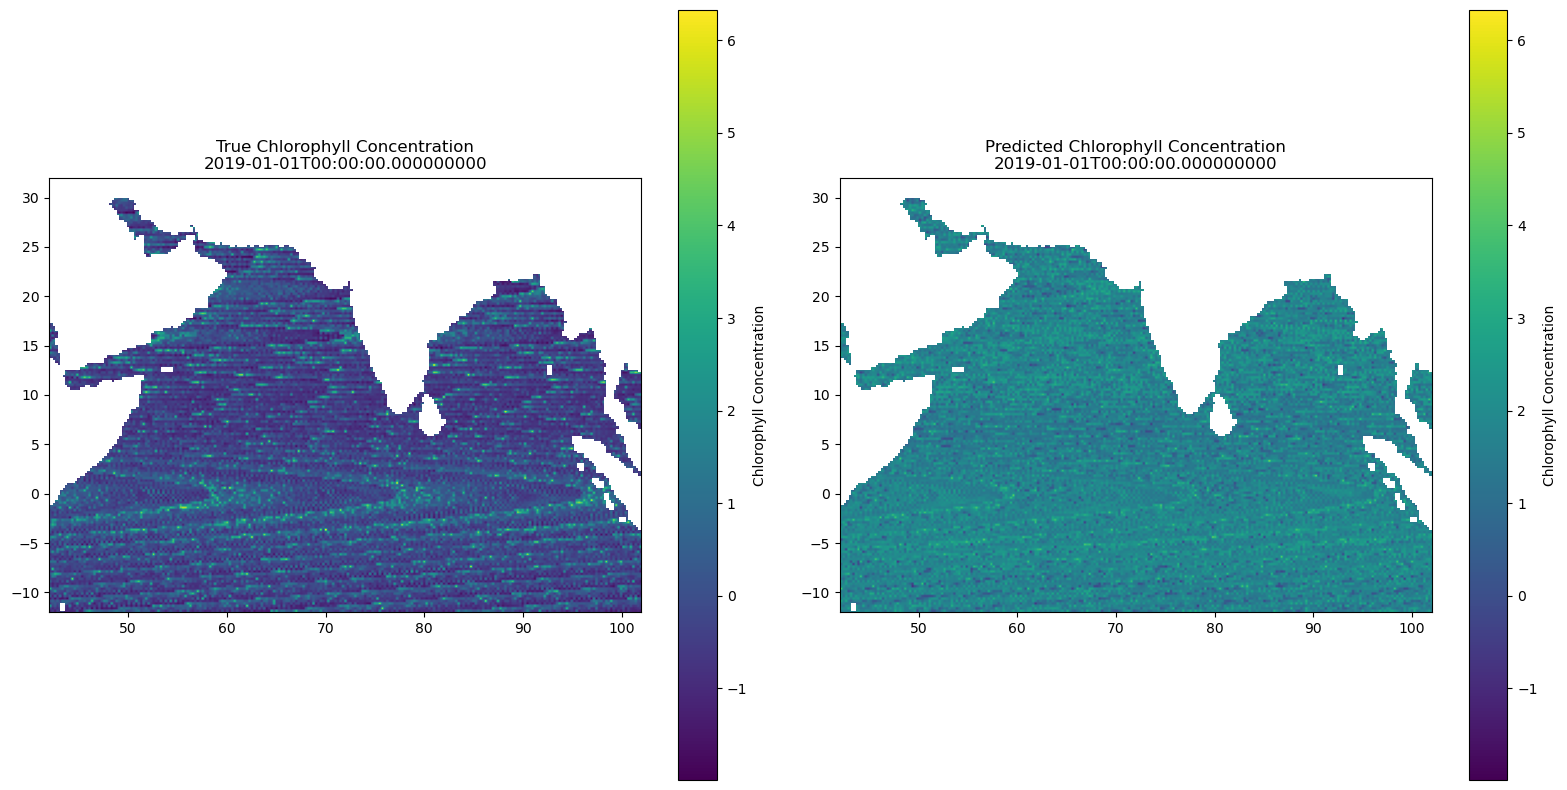

Starting data load and preprocessing...
Preparing data...
Preparing data...
[21:00:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693021084223/work/src/learner.cc:767: 
Parameters: { "device" } are not used.

Calculating daily MAE...


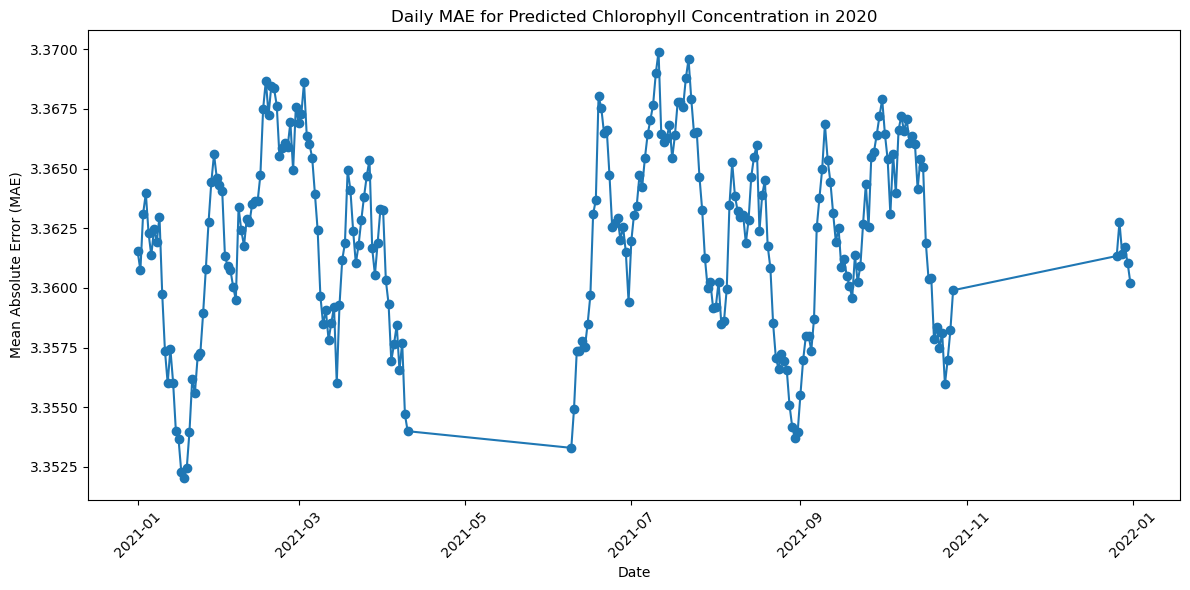

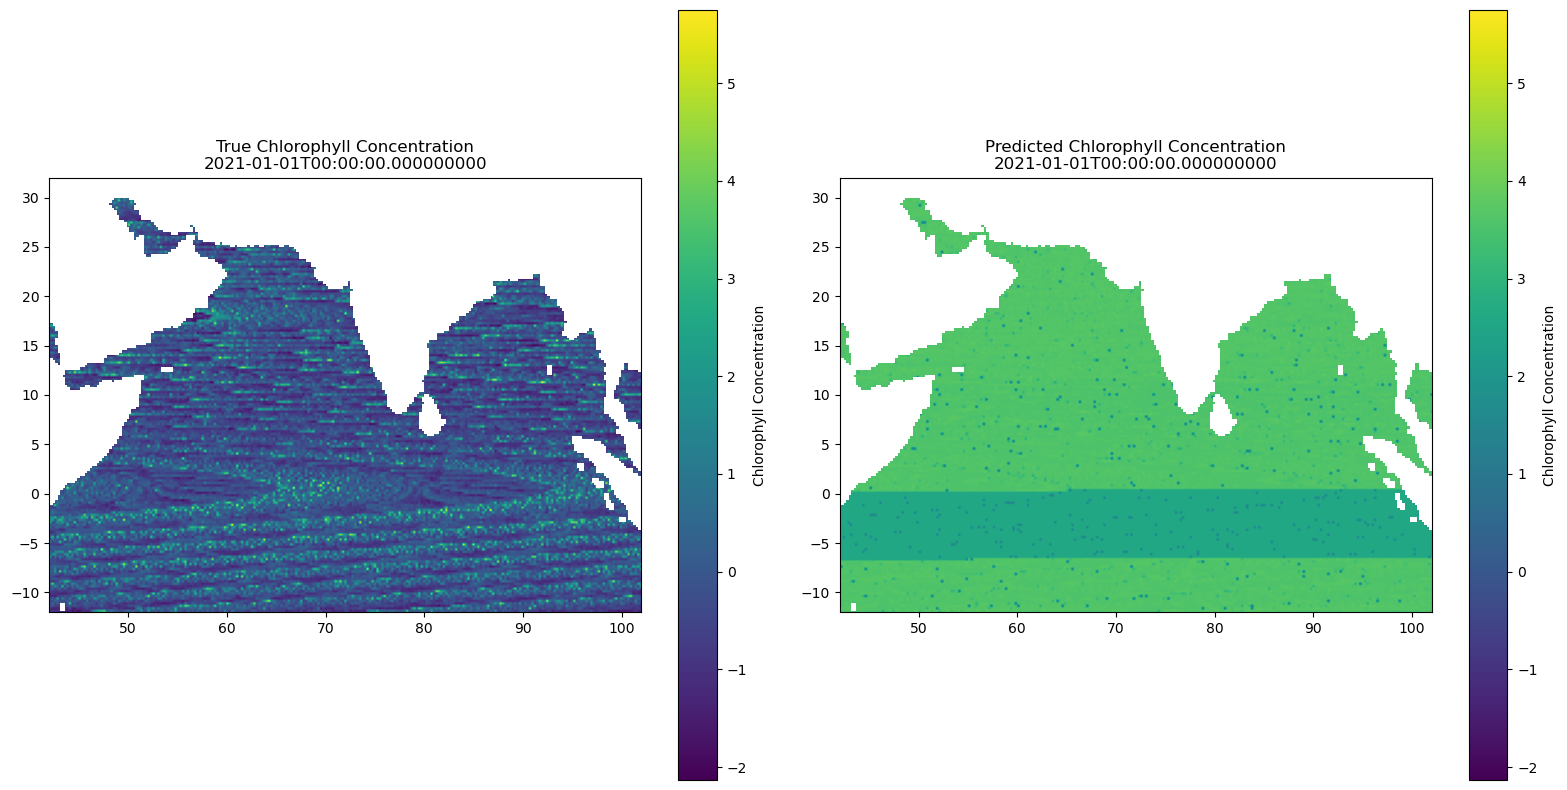

In [11]:
def main():
    zarr_train, zarr_test = load_and_preprocess_data2()
    lat = zarr_train['lat'].values
    lon = zarr_train['lon'].values
    
    X_train, y_train, X_mean, X_std, y_mean, y_std, _, features, water_mask = prepare_data(zarr_train)
    X_test, y_test, _, _, _, _, original_shape, _, _ = prepare_data(zarr_test)
    
    model = XGBRegressor(n_estimators=100, tree_method='hist', random_state=42 , learning_rate= 0.1, device = "cuda")
    model.fit(X_train, y_train)
    
    test_dates = zarr_test.time.values
    daily_mae = calculate_daily_mae(model, X_test, y_test, test_dates)
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, daily_mae, marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Daily MAE for Predicted Chlorophyll Concentration in 2020')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Visualize True and Predicted chlorophyll for an arbitrary day
    arbitrary_index = 0  # Choose any index within the range of available dates
    y_pred_arbitrary_day = model.predict(X_test[arbitrary_index::len(test_dates)])
    y_true_arbitrary_day = y_test[arbitrary_index::len(test_dates)]
    
    plot_chlorophyll_maps(y_true_arbitrary_day, y_pred_arbitrary_day, water_mask, str(test_dates[arbitrary_index]), lat, lon)
    zarr_train, zarr_test = load_and_preprocess_data3()
    lat = zarr_train['lat'].values
    lon = zarr_train['lon'].values
    
    X_train, y_train, X_mean, X_std, y_mean, y_std, _, features, water_mask = prepare_data(zarr_train)
    X_test, y_test, _, _, _, _, original_shape, _, _ = prepare_data(zarr_test)
    
    model = XGBRegressor(n_estimators=100, tree_method='hist', random_state=42 , learning_rate= 0.1, device = "cuda")
    model.fit(X_train, y_train)
    
    test_dates = zarr_test.time.values
    daily_mae = calculate_daily_mae(model, X_test, y_test, test_dates)
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, daily_mae, marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Daily MAE for Predicted Chlorophyll Concentration in 2020')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # Visualize True and Predicted chlorophyll for an arbitrary day
    arbitrary_index = 0  # Choose any index within the range of available dates
    y_pred_arbitrary_day = model.predict(X_test[arbitrary_index::len(test_dates)])
    y_true_arbitrary_day = y_test[arbitrary_index::len(test_dates)]
    
    plot_chlorophyll_maps(y_true_arbitrary_day, y_pred_arbitrary_day, water_mask, str(test_dates[arbitrary_index]), lat, lon)

if __name__ == "__main__":
    main()